In [1]:
remotes::install_github("rstudio/tensorflow")

Skipping install of 'tensorflow' from a github remote, the SHA1 (0ffad97c) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
#install.packages("keras")
install.packages("keras3")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
#library("keras")
library("keras3")

In [4]:
tensorflow::set_random_seed(1)

In [5]:
file_url <- "https://github.com/Jbrich95/pinnEV/blob/main/data/USWild.rda?raw=true"
load(url(file_url))
Y = USWild$BA[127:161, , ]
X = array(dim = c(35, 129, 61, 22))
X[, , , 1] = USWild$X$X.t2m[127:161, , , ]
X[, , , 2] = USWild$X$X.SPI[127:161, , , ]
X[, , , -c(1, 2)] = USWild$X$X.N[127:161, , , 1:20]

In [6]:
dim(X)

[1]  35 129  61  22

Warning message in log(1 + Y[1, , ]):
“NaNs produced”


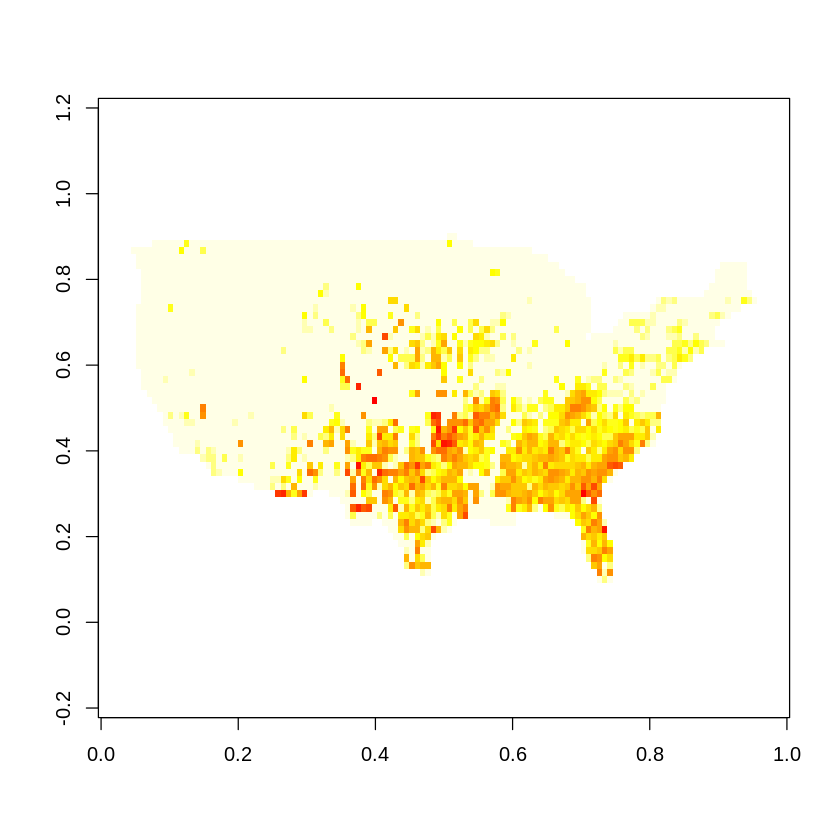

In [7]:
image(log(1 + Y[1, , ]), col = heat.colors(20, rev = T), asp = 0.625)

In [8]:
X.positive <- apply(X, 4, function(x) x[Y > 0])
Y.positive <- sqrt(Y[Y > 0])

In [9]:
means <- apply(X.positive, 2, mean)
sds <- apply(X.positive, 2, sd)
X.scaled <- apply(as.matrix(1:ncol(X.positive)), 1, function(ind)
  (X.positive[, ind] - means[ind]) / sds[ind])

In [10]:
n = length(Y.positive)
train_sample_idx <- sample(1:n, 45000)
test_sample_idx <- sample((1:n)[-train_sample_idx], 5000)
Y_train <- Y.positive[train_sample_idx]
X_train <- X.scaled[train_sample_idx, ]
Y_test <- Y.positive[test_sample_idx]
X_test <- X.scaled[test_sample_idx, ]

In [11]:
model <- keras_model_sequential()

model %>%

  # Adds a densely-connected layer with 64 units to the model:
  layer_dense(units = 64, activation = 'relu') %>%

  # Add another:
  layer_dense(units = 64, activation = 'relu') %>%


  # Add a final layer with 1 ouput
  layer_dense(units = 1, activation = 'linear')

In [12]:
model %>% compile(
  optimizer = "adam",
  loss = "mean_squared_error",
  metrics = list("mean_absolute_error")
)

In [13]:
history <- model %>% fit(
  x = as.matrix(X_train),
  y = as.matrix(log(Y_train)),
  epochs = 100,
  validation_split = 0.2,
  verbose = 1,
  shuffle = T
)

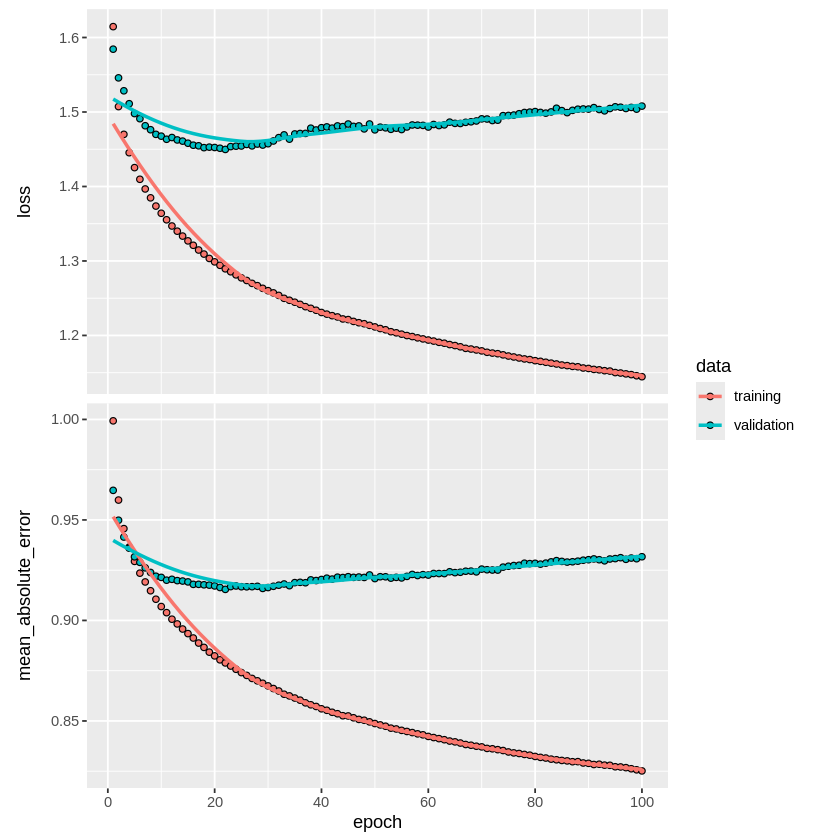

In [14]:
plot(history)

In [15]:
summary(model)

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                     │ (32, 64)                 │         1,472 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_1 (Dense)                   │ (32, 64)                 │         4,160 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_2 (Dense)                   │ (32, 1)                  │            65 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 17,093 (66.77 KB)
 Trainable params: 5,697 (22.25 KB)
 Non-trainable params: 0 (0.00 B)
 Optimizer params: 11,396 (44.52 KB)


In [16]:
model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dense(units = 1, activation = 'linear') %>%
  compile( optimizer = "adam", loss = "mean_squared_error",
           metrics = list("mean_absolute_error"))

checkpoint <- callback_model_checkpoint(
  paste0("checkpoints/LSE.weights.h5"),
  monitor = "val_loss",
  verbose = 0,
  save_best_only = TRUE,
  save_weights_only = TRUE,
  mode = "min",
  save_freq = "epoch"
)



In [17]:
history <- model %>% fit( x = X_train,
                          y = as.matrix(log(Y_train)),
                          epochs=50,
                          batch_size=16,
                            verbose = 1,
                          callbacks = list(checkpoint),
                          validation_split=0.2)

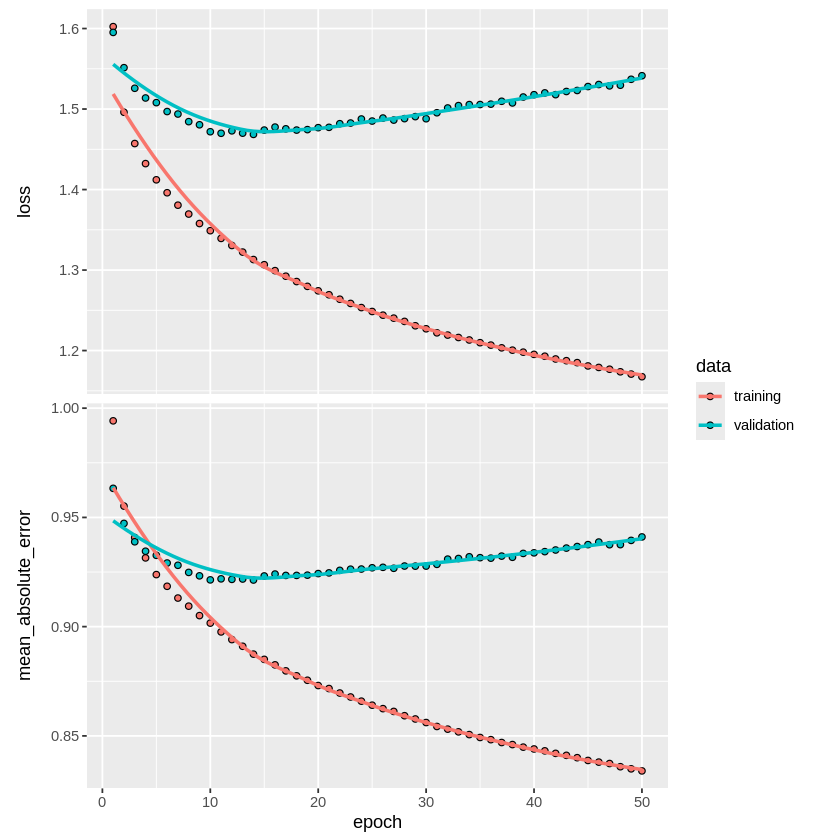

In [18]:
plot(history)

In [19]:
model <- load_model_weights(model,
                                 filepath = paste0("checkpoints/LSE.weights.h5"))

In [20]:
predictions <- model %>% predict(X_test)

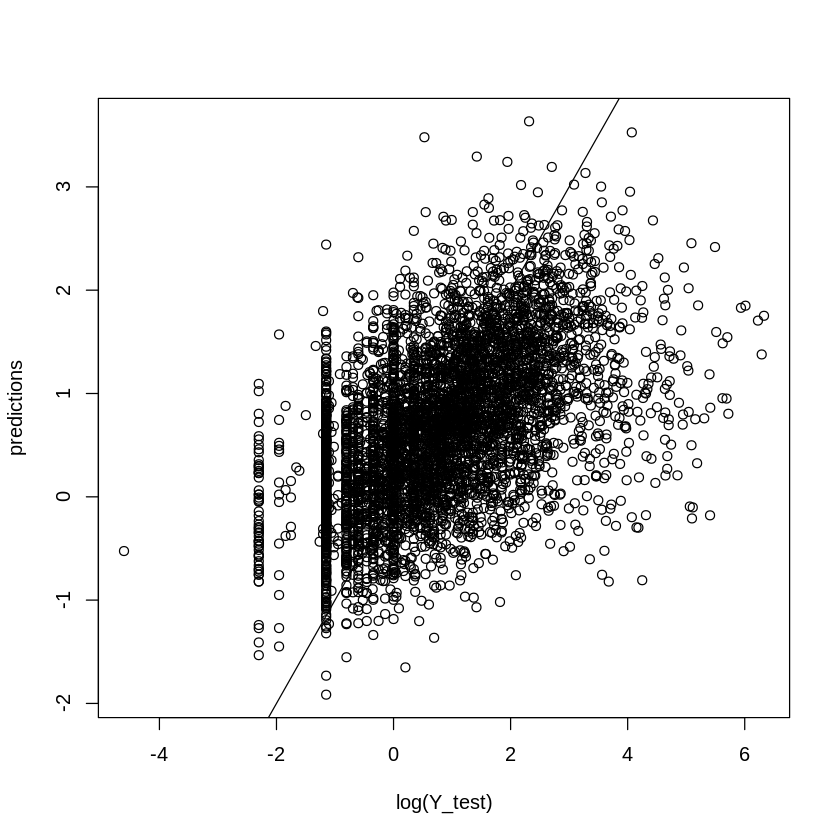

In [21]:
plot(log(Y_test), predictions)
abline(a = 0, b = 1)

In [22]:
linear.model <- keras_model_sequential() %>%
  layer_dense(units = 1, activation = 'linear') %>%
  compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = list("mean_absolute_error")
  )


history <- linear.model %>% fit(
  x = X_train,
  y = as.matrix(log(Y_train)),
  epochs = 15,
  verbose = 0,
  validation_split = 0.2
)

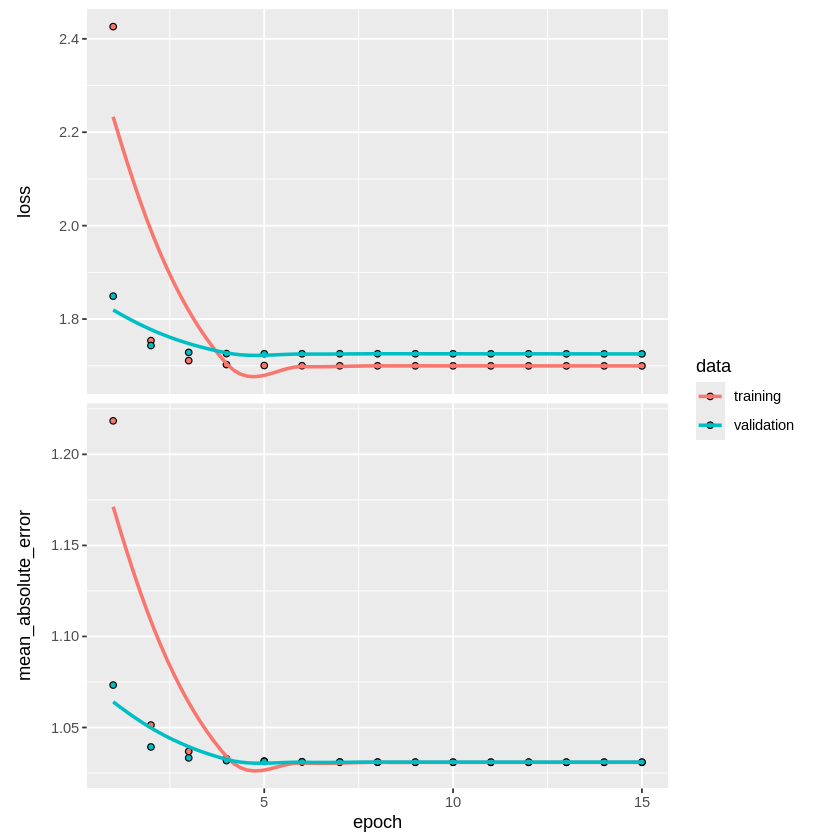

In [23]:
plot(history)

In [24]:
linear_predictions <- linear.model %>% predict(X_test)

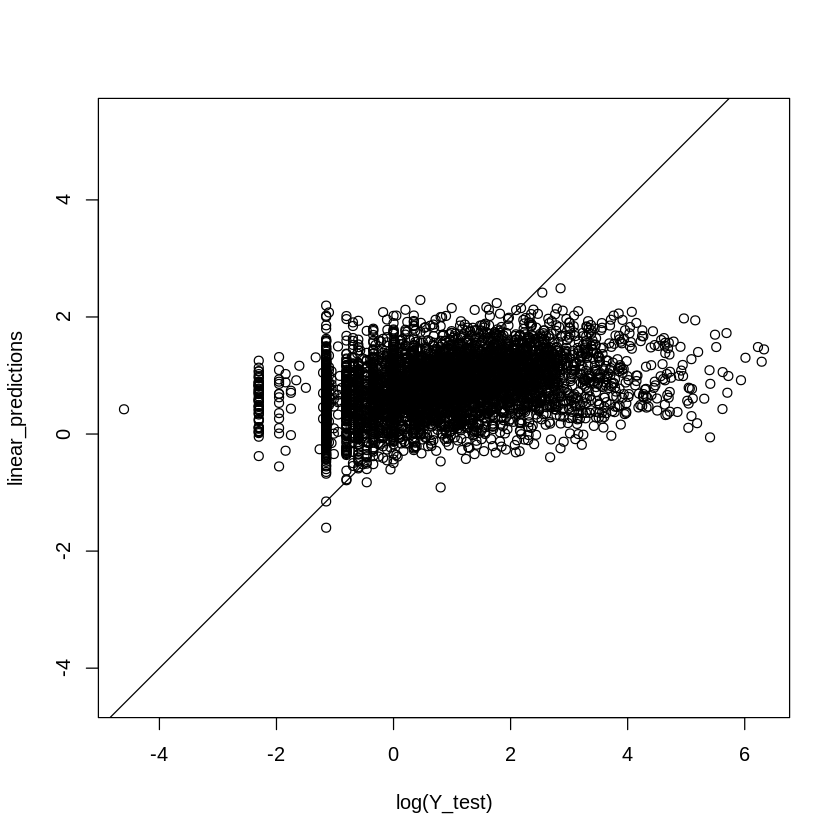

In [25]:
plot(log(Y_test), linear_predictions, asp = 1)
abline(a = 0, b = 1)

In [26]:
par(mfrow = c(1, 3))

t <- 1
X.plot <- X[t, , , ]
dim(X.plot) <- c(prod(dim(X.plot)[1:2]), dim(X.plot)[3])
# Apply scaling
X.plot.scaled <- apply(as.matrix(1:ncol(X.plot)), 1, function(ind)
  (X.plot[, ind] - means[ind]) / sds[ind])

linear.predictions <- linear.model %>% predict(X.plot.scaled)

Warning message in log(Y[t, , ]):
“NaNs produced”


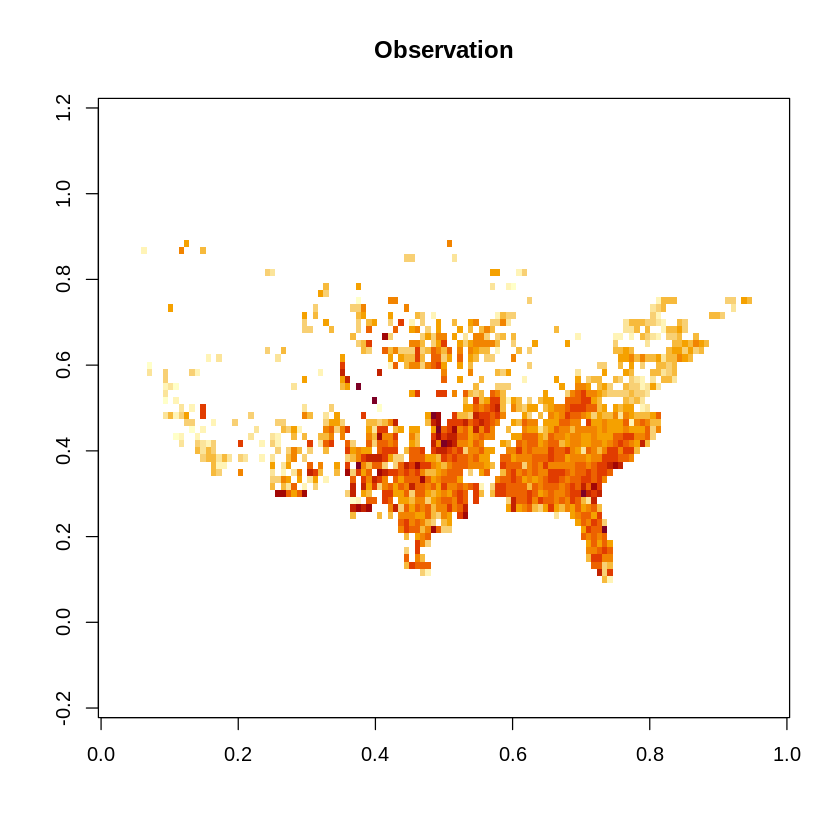

In [27]:
dim(linear.predictions) <- dim(Y)[2:3]
linear.predictions[Y[t, , ] < 0] = NA
#linear.predictions[Y[t, , ] <= 0] = NA #Comment for US-wide prediction
image(log(Y[t, , ]), main = "Observation",asp=0.625)

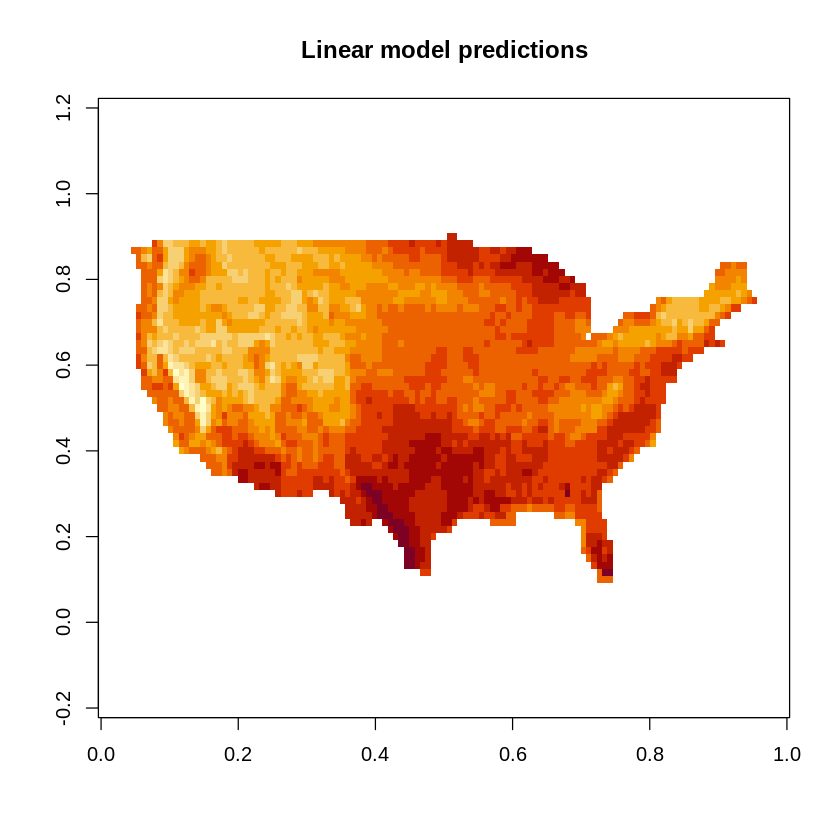

In [28]:


image(linear.predictions, main = "Linear model predictions",asp=0.625)

NN.predictions <- model %>% predict(X.plot.scaled)

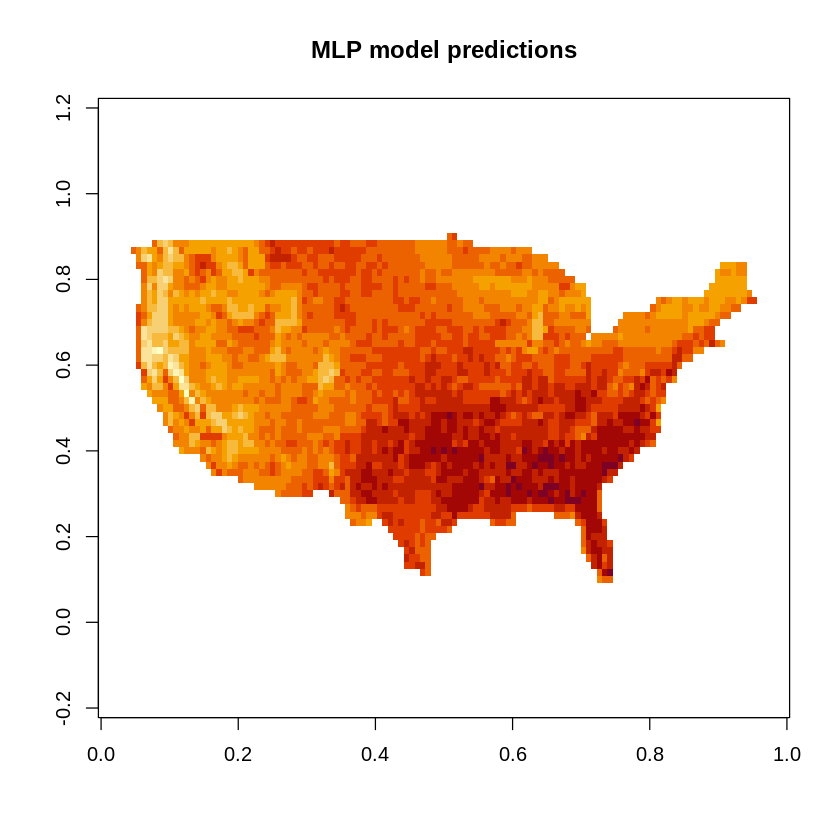

In [29]:


dim(NN.predictions) <- dim(Y)[2:3]
NN.predictions[Y[t, , ] < 0] = NA
#NN.predictions[Y[t, , ] <= 0] = NA #Comment for US-wide prediction
image(NN.predictions, main = "MLP model predictions",asp=0.625)

In [37]:
tau <- 0.8 # Set quantile level
tilted_loss <- function(y_true, y_pred) {
  #K <- backend()

  error = y_true - y_pred
  return(op_mean(op_maximum(tau * error, (tau - 1) * error)))
}

In [38]:
u.model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = 'relu') %>%
  layer_dense(units = 64, activation = 'relu')

In [39]:
u.model <- u.model %>% layer_dense(
  units = 1,
  activation = "exponential")

In [40]:
u.model %>%
  compile(optimizer = "adam", loss = tilted_loss)

checkpoint <- callback_model_checkpoint(
  paste0("checkpoints/u.weights.h5"),
  monitor = "val_loss",
  verbose = 0,
  save_best_only = TRUE,
  save_weights_only = TRUE,
  mode = "min",
  save_freq = "epoch"
)

history <- u.model %>% fit(
  x = X_train,
  y = as.matrix(Y_train),
  batch_size = 64,
  epochs = 40,
    verbose = 0,
  callbacks = list(checkpoint),
  validation_split = 0.2
)

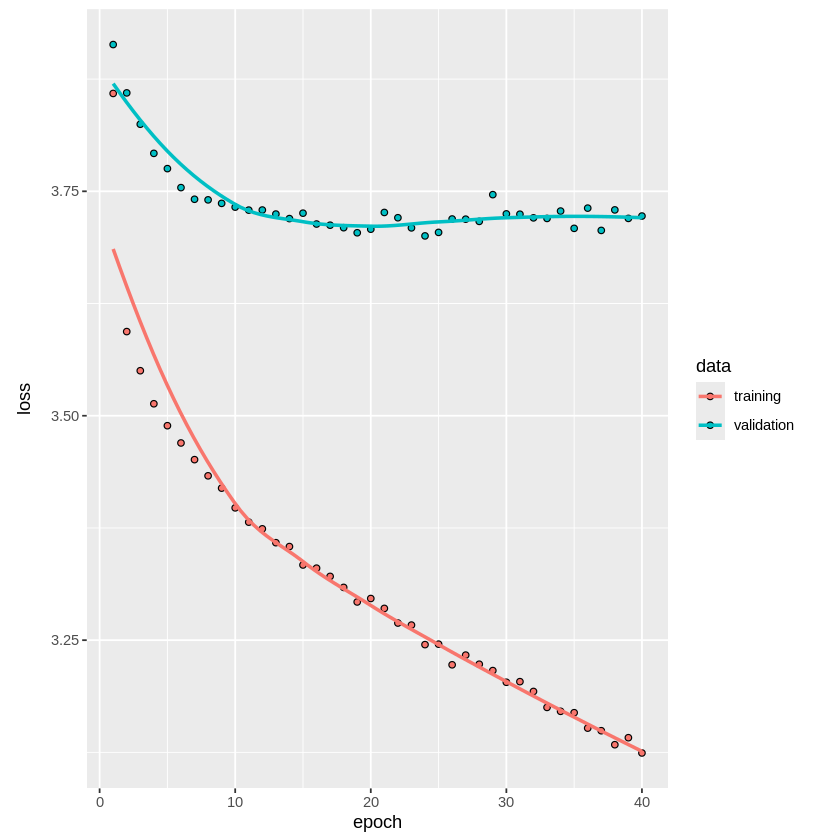

In [41]:
plot(history)

In [42]:
u.model <- load_model_weights(u.model,
                                 filepath = paste0("checkpoints/u.weights.h5"))

In [43]:
test.pred.theshold <- u.model %>% predict(X_test)

In [44]:
mean(Y_test < test.pred.theshold) # Should be close to tau

[1] 0.7724

Warning message in log(Y[t, , ]):
“NaNs produced”


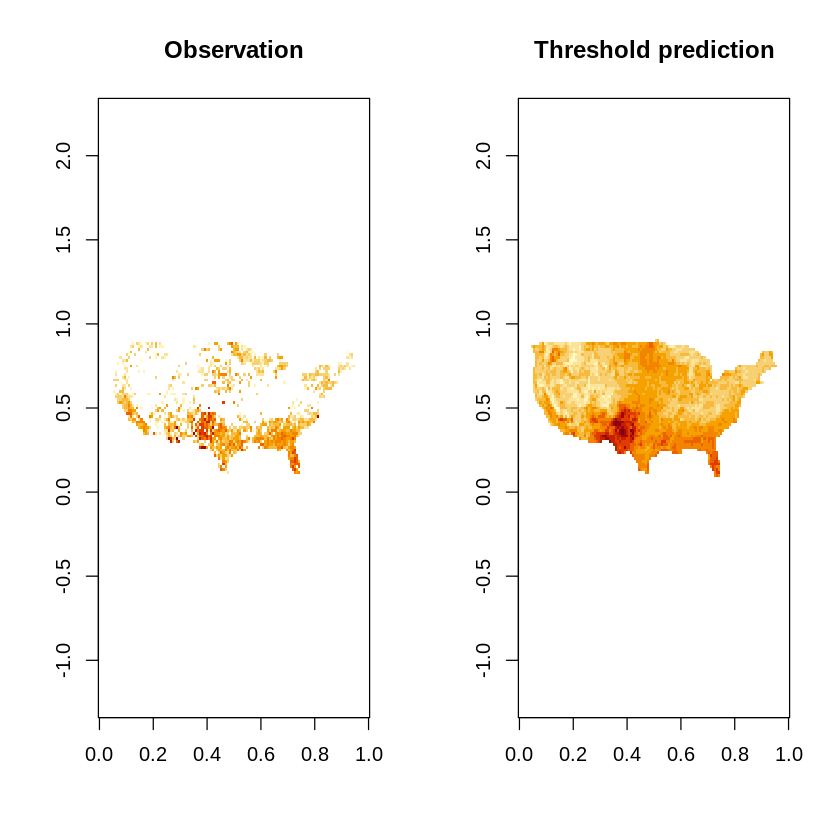

In [45]:
par(mfrow = c(1, 2))

t <- 3
X.plot <- X[t, , , ]
dim(X.plot) <- c(prod(dim(X.plot)[1:2]), dim(X.plot)[3])
# Apply scaling
X.plot.scaled <- apply(as.matrix(1:ncol(X.plot)), 1, function(ind)
  (X.plot[, ind] - means[ind]) / sds[ind])

image(log(Y[t, , ]), main = "Observation", asp = 0.625)

NN.predictions <- u.model %>% predict(X.plot.scaled)

dim(NN.predictions) <- dim(Y)[2:3]
NN.predictions[Y[t, , ] < 0] = NA
#NN.predictions[Y[t, , ] <= 0] = NA #Comment to provide US-wide predictions.
image(log(NN.predictions), main = "Threshold prediction", asp = 0.625)
